## Constrained geometry optimizations with the AMSWorker

The `AMSWorker` class allows geometry optimization of multiple molecules without the overhead of AMS start-up for each molecule.
Here we want to optimize the geometries of three different molecules, with benzene as the common substructure,
but wit different substituents.

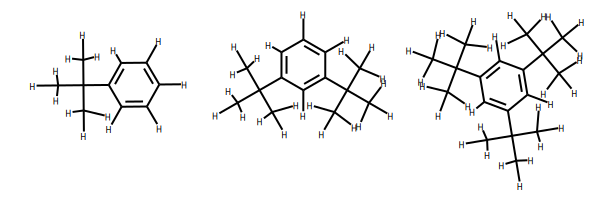

In [1]:
import os
from scm.plams import Molecule
from scm.plams import plot_grid_molecules

path = os.path.join(os.environ["AMSRESOURCES"], "Molecules", "TestMols", "PLAMS")
filenames = ["tbut_benzene.in", "o_di_tbut_benzene.in", "tri_tbut_benzene.in"]
filenames = [os.path.join(path, fn) for fn in filenames]
molecules = [Molecule(fn) for fn in filenames]

plot_grid_molecules(molecules, molsPerRow=3)

The structures are unoptimized, as the crowded geometry of the third structure demonstrates.

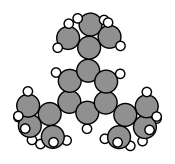

In [2]:
from scm.plams import plot_molecule

plot_molecule(molecules[2]);

The geometry of the three structures can be optimized with the AMSWorker as follows.

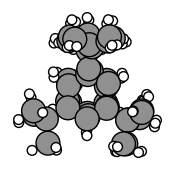

In [3]:
from scm.plams import AMSWorker, Settings

# Create the general settings object and start upt the amsworker
settings = Settings()
settings.input.ForceField.Type = "UFF"
worker = AMSWorker(settings)

stackmol = Molecule()
for i, mol in enumerate(molecules):
    results = worker.GeometryOptimization("go%i" % (i), mol)
    stackmol += results.get_main_molecule()

plot_molecule(stackmol);

We may prefer to perform the optimization while constraining the positions of the benzene carbon atoms, so that the benzene rings can be stacked directly on top of one another. The constraints can be passed to the `GeometryOptimization()` call as a settings object. The settings object has the same layout as the constraints passed to a regular `AMSJob`.

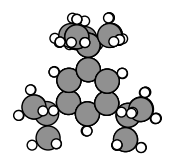

In [4]:
stackmol = Molecule()
s = Settings()
s.input.ams.Constraints.Atom = [1, 2, 3, 4, 5, 6]
for i, mol in enumerate(molecules):
    # Pass the constraints to the optimizer
    results = worker.GeometryOptimization("constrained%i" % (i), mol, constraints=s)
    stackmol += results.get_main_molecule()

plot_molecule(stackmol);

If we use contraints designed for one molecule in a geometry optimization for a different molecule, this may result in an error. We can look at the error message to check.

In [5]:
from scm.plams import JobError
from scm.plams import from_smiles
from scm.amspipe import AMSPipeError

results = worker.GeometryOptimization("water", from_smiles("O"), constraints=s)
print(results.get_errormsg())

Atom index 4 read from Constraints%Atom[4] is out of range.


In [6]:
worker.stop();